In [1]:
import multiprocessing
import dadi
import pandas as pd
import numpy as np
import random
import argparse
from itertools import product
import matplotlib.pyplot as plt
import tskit
import numpy
import seaborn as sns

<h2>Equilibrium population</h2>

In [ ]:
#Set pts for dadi
ns = np.array([20])
pts_l = [20, 40, 60]
indivs = pd.read_csv(r"/home/vivak/chimerism/results/demog_only/eq/rr_fixed_mu_fixed/chimeric/individuals_count.txt", names=['rep','N'], sep='\t')

#Run dadi on WF sfs to infer theta for eq model
wf_res = []
for i in range(0, 100):
    try:
        fs = dadi.Spectrum.from_file(r"/home/vivak/chimerism/results/demog_only/eq/rr_fixed_mu_fixed/WF/rep"+str(i)+"/dadi/pop0.sfs")
        func = dadi.Demographics1D.snm
        # Make the extrapolating version of our demographic model function.
        func_ex = dadi.Numerics.make_extrap_func(func)
        params = ["notused"]
        lp=[100]
        up=[10000]
        # popt = dadi.Inference.optimize(params, fs, func_ex, pts_l, lower_bound=lp,
        # upper_bound=up, verbose=False, full_output=True, maxiter=3)
        model = func_ex( params, ns, pts_l)
        # Likelihood of the data given the model AFS.
        ll_model = dadi.Inference.ll_multinom(model, fs)
        theta = dadi.Inference.optimal_sfs_scaling(model, fs)
        N = theta/(2.5e-8*1000000*4)
        wf_res.append([theta, N, N/10000, ll_model])
    except Exception:
        pass

#Run dadi on chimeric sfs to infer theta for eq model    
c_res = []
for i in range(1, 101):
    fs = dadi.Spectrum.from_file(r"/home/vivak/chimerism/dadi/sfs_files/demog_only/eq/rr_fixed_mu_fixed/rep"+str(i)+"_chimeric.sfs")
    func = dadi.Demographics1D.snm
    # Make the extrapolating version of our demographic model function.
    func_ex = dadi.Numerics.make_extrap_func(func)
    params = ["notused"]
    lp=[100]
    up=[10000]
    # popt = dadi.Inference.optimize(params, fs, func_ex, pts_l, lower_bound=lp,
    # upper_bound=up, verbose=False, full_output=True, maxiter=3)
    model = func_ex( params, ns, pts_l)
    # Likelihood of the data given the model AFS.
    ll_model = dadi.Inference.ll_multinom(model, fs)
    theta = dadi.Inference.optimal_sfs_scaling(model, fs)
    N = theta/(2.5e-8*1000000*4)
    c_res.append([theta, N, N/int(indivs[indivs.rep==i].N), ll_model])  
    
pd.DataFrame(wf_res, columns = ['theta','N', 'Ninf/Ntrue' ,'log-likelihood']).to_csv("/home/vivak/chimerism/dadi/WF/eq.txt", header=True, index=False, sep='\t')
pd.DataFrame(c_res, columns = ['theta','N', 'Ninf/Ntrue' ,'log-likelihood']).to_csv("/home/vivak/chimerism/dadi/chimeric/eq.txt", header=True, index=False, sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: '/home/vivak/chimerism/results/demog_only/eq/rr_fixed_mu_fixed/chimeric/individuals_count.txt'

In [202]:
indivs = pd.read_csv(r"/home/vivak/chimerism/results/demog_only/eq/rr_fixed_mu_fixed/chimeric/individuals_count.txt", names=['rep','N'], sep='\t')

#Load in fsc sim results
rdf = pd.DataFrame()
for i in range(0, 100):
    fsc_WF = pd.read_csv("/home/vivak/chimerism/fsc/WF/eq/rep"+str(i)+".txt", names=['N', 'maxEstLhood', 'maxObsLhood'], sep='\t')
    fsc_WF['lhood'] = fsc_WF.maxObsLhood - fsc_WF.maxEstLhood
    fsc_WF = fsc_WF[fsc_WF.lhood==fsc_WF.lhood.min()].drop_duplicates()
    fsc_WF['N'] = fsc_WF.N/2
    fsc_WF['Ninf/Ntrue'] = fsc_WF.N / 10000
    rdf = pd.concat([rdf, fsc_WF]).reset_index(drop=True)

rdf.to_csv("/home/vivak/chimerism/fsc/WF/eq.txt", header=True, index=False, sep='\t')

rdf = pd.DataFrame()
for i in range(1, 101):
    fsc_WF = pd.read_csv("/home/vivak/chimerism/fsc/chimeric/eq/rep"+str(i)+".txt", names=['N', 'maxEstLhood', 'maxObsLhood'], sep='\t')
    fsc_WF['lhood'] = fsc_WF.maxObsLhood - fsc_WF.maxEstLhood
    fsc_WF = fsc_WF[fsc_WF.lhood==fsc_WF.lhood.min()].drop_duplicates()
    fsc_WF['N'] = fsc_WF.N/2
    fsc_WF['Ninf/Ntrue'] = fsc_WF.N / int(indivs[indivs.rep==i].N)
    rdf = pd.concat([rdf, fsc_WF]).reset_index(drop=True)
rdf.to_csv("/home/vivak/chimerism/fsc/chimeric/eq.txt", header=True, index=False, sep='\t')

In [2]:
w_stats = pd.read_csv(r"/home/vivak/chimerism/summary_stats/demog/WF.txt", sep='\t', header=0)
w_stats = w_stats[w_stats.demography=='eq'][['thetaw', 'tajimasd', 'meanrsq', 'meanDprime', 'hapdiv', 'numsingletons']]
w_stats['thetaw'] = w_stats.thetaw / 1000000
c_stats = pd.read_csv(r"/home/vivak/chimerism/summary_stats/demog/chimeric.txt", sep='\t', header=0)
c_stats = c_stats[c_stats.demography=='eq'][['thetaw', 'tajimasd', 'meanrsq', 'meanDprime', 'hapdiv', 'numsingletons']]
c_stats['thetaw'] = c_stats.thetaw / 1000000


In [23]:
#############START FROM HERE ONCE ABOVE FILES HAVE ALREADY BEEN CREATED###############
fsc_w = pd.read_csv("/home/vivak/chimerism/fsc/WF/eq.txt", header=0, sep='\t')
fsc_c = pd.read_csv("/home/vivak/chimerism/fsc/chimeric/eq.txt", header=0, sep='\t')
dadi_w = pd.read_csv("/home/vivak/chimerism/dadi/WF/eq.txt", header=0, sep='\t')
dadi_c = pd.read_csv("/home/vivak/chimerism/dadi/chimeric/eq.txt", header=0, sep='\t')

In [24]:
df = pd.DataFrame([list(dadi_w['Ninf/Ntrue']), list(dadi_c['Ninf/Ntrue']),
                  list(fsc_w['Ninf/Ntrue']), list(fsc_c['Ninf/Ntrue'])]).T
rdf = df.describe()

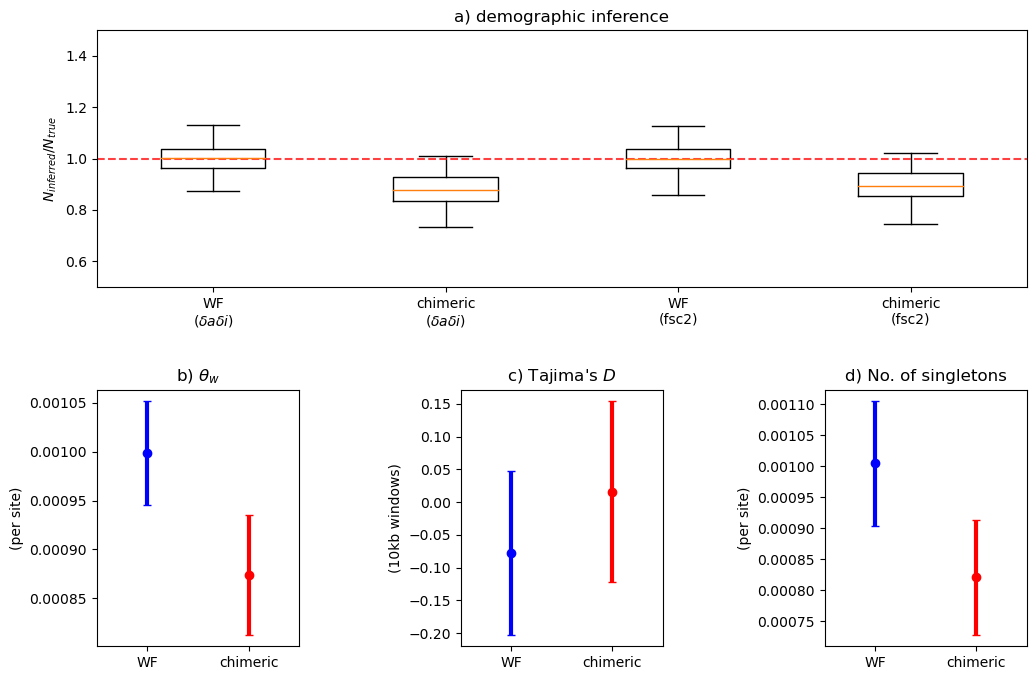

In [25]:
labels = ['WF\n($\delta$$a$$\delta$$i$)', 'chimeric\n($\delta$$a$$\delta$$i$)',
         'WF\n(fsc2)', 'chimeric\n(fsc2)']

# create dictionaries for each column as items of a list
bxp_stats = rdf.apply(lambda x: {'med':x['mean'], 'q1':x['25%'], 'q3':x['75%'], 'whislo':x['min'], 'whishi':x['max']}, axis=0).tolist()

# add the column names as labels to each dictionary entry
for index, item in enumerate(bxp_stats):
    item.update({'label':labels[index]})

plt.figure(figsize=(12, 8))
ax = plt.subplot(2,1,1)
ax2 = plt.subplot(2,3,4)
ax3 = plt.subplot(2,3,5)
ax4 = plt.subplot(2,3,6)
# ax5 = plt.subplot(2,5,9)
# ax6 = plt.subplot(2,5,10)

ax.bxp(bxp_stats, showfliers=False);
ax.set_ylim([0.5,1.5])
ax.axhline(1, color='r', linestyle='--', alpha=0.75) 
ax.set_ylabel(r"$N_{inferred} / N_{true}$")
ax.set_title(r'a) demographic inference')

ax2.errorbar([0.5], w_stats['thetaw'].mean(), w_stats['thetaw'].std(),
            fmt='o', lw=3, capsize=3, zorder=15, c='b', label='WF')
ax2.errorbar([1], c_stats['thetaw'].mean(), c_stats['thetaw'].std(),
            fmt='o', lw=3, capsize=3, zorder=15, c='r', label='chimeric') 
ax2.set_xlim([0.25,1.25])
ax2.set_xticks([0.5, 1])
ax2.set_xticklabels(['WF','chimeric'])
ax2.set_title(r'b) $\theta_w$')
ax2.set_ylabel('(per site)')

ax3.errorbar([0.5], w_stats['tajimasd'].mean(), w_stats['tajimasd'].std(),
            fmt='o', lw=3, capsize=3, zorder=15, c='b', label='WF')
ax3.errorbar([1], c_stats['tajimasd'].mean(), c_stats['tajimasd'].std(),
            fmt='o', lw=3, capsize=3, zorder=15, c='r', label='chimeric') 
ax3.set_xlim([0.25,1.25])
ax3.set_xticks([0.5, 1])
ax3.set_xticklabels(['WF','chimeric'])
ax3.set_title("c) Tajima's " + r"$D$")
ax3.set_ylabel('(10kb windows)')

ax4.errorbar([0.5], w_stats['numsingletons'].mean(), w_stats['numsingletons'].std(),
            fmt='o', lw=3, capsize=3, zorder=15, c='b', label='WF')
ax4.errorbar([1], c_stats['numsingletons'].mean(), c_stats['numsingletons'].std(),
            fmt='o', lw=3, capsize=3, zorder=15, c='r', label='chimeric') 
ax4.set_xlim([0.25,1.25])
ax4.set_xticks([0.5, 1])
# ax4.set_ylim([0.5e-9, 1.5e-9])
# ax4.set_yticks([0.5e-9, 0.75e-9, 1e-9, 1.25e-9, 1.5e-9])
# ax4.set_yticklabels(['0.5e-9', '0.75e-9', '1e-9', '1.25e-9', '1.5e-9'])
ax4.set_xticklabels(['WF','chimeric'])
ax4.set_title('d) No. of singletons')
ax4.set_ylabel('(per site)')


# ax5.errorbar([0.5], w_stats['meanDprime'].mean(), w_stats['meanDprime'].std(),
#             fmt='o', lw=3, capsize=3, zorder=15, c='b', label='WF')
# ax5.errorbar([1], c_stats['meanDprime'].mean(), c_stats['meanDprime'].std(),
#             fmt='o', lw=3, capsize=3, zorder=15, c='r', label='chimeric') 
# ax5.set_xlim([0.25,1.25])
# ax5.set_xticks([0.5, 1])
# ax5.set_xticklabels(['WF','chimeric'])
# ax5.set_title("e) mean $D'$")
# ax5.set_ylabel('(10kb windows)')


# ax6.errorbar([0.5], w_stats['hapdiv'].mean(), w_stats['hapdiv'].std(),
#             fmt='o', lw=3, capsize=3, zorder=15, c='b', label='WF')
# ax6.errorbar([1], c_stats['hapdiv'].mean(), c_stats['hapdiv'].std(),
#             fmt='o', lw=3, capsize=3, zorder=15, c='r', label='chimeric') 
# ax6.set_xlim([0.25,1.25])
# ax6.set_xticks([0.5, 1])
# ax6.set_xticklabels(['WF','chimeric'])
# ax6.set_title('f) haplotype diversity')
# ax6.set_ylabel('(per site)')

# #Adjust spacing between subplots
plt.subplots_adjust(wspace=0.8, hspace=0.4)
#plt.suptitle(r"Equilibrium population")
plt.savefig('/home/vivak/chimerism/plots/eq.png', format='png', bbox_inches='tight')

<h2>Parsing results for pop size change</h2>

In [208]:
#Parse dadi results for best fits for each replicate, then output to file for all pop size change scenarios
demog = {'expansion':20000, 'contraction':5000, 'bneck':1000}
for dem in demog.keys():
    indivs = pd.read_csv(r"/home/vivak/chimerism/results/demog_only/"+dem+"/rr_fixed_mu_fixed/chimeric/individuals_count.txt", names=['rep','N'], sep='\t')
    rdf = pd.DataFrame()
    for i in range(0, 100):
        try:
            d = pd.read_csv(r"/home/vivak/chimerism/dadi/WF/"+dem+"/rep"+str(i)+".txt", header=0, sep='\t')
            d = d[d['log-likelihood']==d['log-likelihood'].max()]
            rdf = pd.concat([rdf, d])
        except Exception:
            pass
    rdf['Ncurrent'] = rdf.N * rdf.nu
    rdf['T_gens'] = 2 * rdf.N * rdf['T']
    rdf['Nanc/Ntrue'] = rdf.N / 10000
    rdf['Ncurr/Ntrue'] = rdf.Ncurrent / demog[dem]
    rdf['T/Ttrue'] = rdf.T_gens / demog[dem]
    rdf.to_csv(r"/home/vivak/chimerism/dadi/WF/"+dem+".txt", header=True, sep='\t', index=False)

    rdf = pd.DataFrame()
    for i in range(1, 101):
        try:
            d = pd.read_csv(r"/home/vivak/chimerism/dadi/chimeric/"+dem+"/rep"+str(i)+".txt", header=0, sep='\t')
            d = d[d['log-likelihood']==d['log-likelihood'].max()]
            d['Ncurrent'] = d.N * d.nu
            d['T_gens'] = 2 * d.N * d['T']
            d['Ncurrent'] = d.N * d.nu
            d['T_gens'] = 2 * d.N * d['T']
            d['Nanc/Ntrue'] = d.N / 10000
            d['Ncurr/Ntrue'] = d.Ncurrent / int(indivs[indivs.rep==i].N)
            d['T/Ttrue'] = d.T_gens / demog[dem]    
            rdf = pd.concat([rdf, d])
        except Exception:
            pass
    rdf.to_csv(r"/home/vivak/chimerism/dadi/chimeric/"+dem+".txt", header=True, sep='\t', index=False)

In [258]:
demog = {'expansion':20000, 'contraction':5000, 'bneck':1000}
for dem in demog.keys():
    indivs = pd.read_csv(r"/home/vivak/chimerism/results/demog_only/"+dem+"/rr_fixed_mu_fixed/chimeric/individuals_count.txt", names=['rep','N'], sep='\t')
    #Load in fsc sim results
    rdf = pd.DataFrame()
    for i in range(0, 100):
        try:
            fsc_WF = pd.read_csv("/home/vivak/chimerism/fsc/WF/"+dem+"/rep"+str(i)+".txt", 
                                 names=['Ncurr', 'Nanc', 'T', 'curr/anc ratio', 'maxEstLhood', 'maxObsLhood'], sep='\t')
            fsc_WF['lhood'] = fsc_WF.maxObsLhood - fsc_WF.maxEstLhood
            fsc_WF = fsc_WF[fsc_WF.lhood==fsc_WF.lhood.min()].drop_duplicates()
            fsc_WF['Ncurr'] = fsc_WF.Ncurr/2
            fsc_WF['Nanc'] = fsc_WF.Nanc/2
            fsc_WF['Ncurr/Ntrue'] = fsc_WF.Ncurr / demog[dem]
            fsc_WF['Nanc/Ntrue'] = fsc_WF.Nanc / 10000
            fsc_WF['T/Ttrue'] = fsc_WF['T'] / demog[dem]
            rdf = pd.concat([rdf, fsc_WF]).reset_index(drop=True)
        except Exception:
            pass
    rdf.to_csv("/home/vivak/chimerism/fsc/WF/"+dem+".txt", header=True, index=False, sep='\t')

    rdf = pd.DataFrame()
    for i in range(1, 101):
        try:
            fsc_WF = pd.read_csv("/home/vivak/chimerism/fsc/chimeric/"+dem+"/rep"+str(i)+".txt", 
                                 names=['Ncurr', 'Nanc', 'T', 'curr/anc ratio', 'maxEstLhood', 'maxObsLhood'], sep='\t')
            fsc_WF['lhood'] = fsc_WF.maxObsLhood - fsc_WF.maxEstLhood
            fsc_WF = fsc_WF[fsc_WF.lhood==fsc_WF.lhood.min()].drop_duplicates()
            fsc_WF['Ncurr'] = fsc_WF.Ncurr/2
            fsc_WF['Nanc'] = fsc_WF.Nanc/2
            fsc_WF['Ncurr/Ntrue'] = fsc_WF.Ncurr / int(indivs[indivs.rep==i].N)
            fsc_WF['Nanc/Ntrue'] = fsc_WF.Nanc / 10000
            fsc_WF['T/Ttrue'] = fsc_WF['T'] / demog[dem]
            rdf = pd.concat([rdf, fsc_WF]).reset_index(drop=True)
        except Exception:
            pass
    rdf.to_csv("/home/vivak/chimerism/fsc/chimeric/"+dem+".txt", header=True, index=False, sep='\t')

<h2>Population Size Change</h2>

In [21]:
# ylims = {'expansion':[1.25e-9, 2.25e-9], 'contraction':[2.5e-10, 1e-9], 'bneck':[1e-10, 5e-10]}
# yticks = {'expansion':[1.25e-9, 1.5e-9, 1.75e-9, 2e-9, 2.25e-9], 'contraction':[2.5e-10, 5e-10, 7.5e-10, 1e-9], 'bneck':[1e-10, 2e-10, 3-10, 4e-10, 5e-9]}
# yticklabs = {'expansion':['1.25e-9', '1.5e-9', '1.75e-9', '2e-9', '2.25e-9'], 
#              'contraction':['0.25e-9', '0.5e-9', '0.75e-9', '1e-9'], 
#              'bneck':['1e-10', '2e-10', '3e-10', '4e-10', '5e-10']}

demog = {'expansion':20000, 'contraction':5000, 'bneck':1000}
for dem in demog.keys():
    w_stats = pd.read_csv(r"/home/vivak/chimerism/summary_stats/demog/WF.txt", sep='\t', header=0)
    w_stats = w_stats[w_stats.demography==dem][['thetaw', 'tajimasd', 'meanrsq', 'meanDprime', 'hapdiv', 'numsingletons']]
    w_stats['thetaw'] = w_stats.thetaw / 1000000
    c_stats = pd.read_csv(r"/home/vivak/chimerism/summary_stats/demog/chimeric.txt", sep='\t', header=0)
    c_stats = c_stats[c_stats.demography==dem][['thetaw', 'tajimasd', 'meanrsq', 'meanDprime', 'hapdiv', 'numsingletons']]
    c_stats['thetaw'] = c_stats.thetaw / 1000000
    
    fsc_w = pd.read_csv("/home/vivak/chimerism/fsc/WF/"+dem+".txt", header=0, sep='\t')
    fsc_c = pd.read_csv("/home/vivak/chimerism/fsc/chimeric/"+dem+".txt", header=0, sep='\t')
    dadi_w = pd.read_csv("/home/vivak/chimerism/dadi/WF/"+dem+".txt", header=0, sep='\t')
    dadi_c = pd.read_csv("/home/vivak/chimerism/dadi/chimeric/"+dem+".txt", header=0, sep='\t')

    labels = ['$N_{current}$\nWF', '$N_{current}$\nchimeric',
             '$N_{ancestral}$\nWF', '$N_{ancestral}$\nchimeric',
             '$T$\nWF', '$T$\nchimeric']

    plt.figure(figsize=(12, 10))
    ax = plt.subplot(3,1,1)
    ax2 = plt.subplot(3,1,2)
    ax3 = plt.subplot(3,3,7)
    ax4 = plt.subplot(3,3,8)
    ax5 = plt.subplot(3,3,9)
    # ax6 = plt.subplot(3,5,14)
    # ax7 = plt.subplot(3,5,15)

    df = pd.DataFrame([list(dadi_w['Ncurr/Ntrue']), list(dadi_c['Ncurr/Ntrue']), 
                       list(dadi_w['Nanc/Ntrue']), list(dadi_c['Nanc/Ntrue']), 
                      list(dadi_w['T/Ttrue']), list(dadi_c['T/Ttrue'])]).T
    rdf = df.describe()
    # create dictionaries for each column as items of a list
    bxp_stats = rdf.apply(lambda x: {'med':x['mean'], 'q1':x['25%'], 'q3':x['75%'], 'whislo':x['min'], 'whishi':x['max']}, axis=0).tolist()

    # add the column names as labels to each dictionary entry
    for index, item in enumerate(bxp_stats):
        item.update({'label':labels[index]})
    ax.bxp(bxp_stats, showfliers=False);
    #ax.set_ylim([0.5,1.5])
    ax.axhline(1, color='g', linestyle='--', alpha=0.75) 
    ax.set_ylabel(r"$\delta$$a$$\delta$$i$ inferred/" + "\n" + "true value")
    ax.set_title(r"a) $\delta$$a$$\delta$$i$ inference results") 
    df = pd.DataFrame([list(fsc_w['Ncurr/Ntrue']), list(fsc_c['Ncurr/Ntrue']), 
                       list(fsc_w['Nanc/Ntrue']), list(fsc_c['Nanc/Ntrue']), 
                      list(fsc_w['T/Ttrue']), list(fsc_c['T/Ttrue'])]).T
    rdf = df.describe()
    # create dictionaries for each column as items of a list
    bxp_stats = rdf.apply(lambda x: {'med':x['mean'], 'q1':x['25%'], 'q3':x['75%'], 'whislo':x['min'], 'whishi':x['max']}, axis=0).tolist()

    # add the column names as labels to each dictionary entry
    for index, item in enumerate(bxp_stats):
        item.update({'label':labels[index]})
    ax2.bxp(bxp_stats, showfliers=False);
    #ax.set_ylim([0.5,1.5])
    ax2.axhline(1, color='g', linestyle='--', alpha=0.75) 
    ax2.set_ylabel(r"fsc2 inferred/" + "\n" + "true value")
    ax2.set_title(r"b) fastsimcoal2 inference results")


    ax3.errorbar([0.5], w_stats['thetaw'].mean(), w_stats['thetaw'].std(),
                fmt='o', lw=3, capsize=3, zorder=15, c='b', label='WF')
    ax3.errorbar([1], c_stats['thetaw'].mean(), c_stats['thetaw'].std(),
                fmt='o', lw=3, capsize=3, zorder=15, c='r', label='chimeric') 
    ax3.set_xlim([0.25,1.25])
    ax3.set_xticks([0.5, 1])
    ax3.set_xticklabels(['WF','chimeric'])
    ax3.set_title(r'c) $\theta_w$')
    ax3.set_ylabel('(per site)')

    ax4.errorbar([0.5], w_stats['tajimasd'].mean(), w_stats['tajimasd'].std(),
                fmt='o', lw=3, capsize=3, zorder=15, c='b', label='WF')
    ax4.errorbar([1], c_stats['tajimasd'].mean(), c_stats['tajimasd'].std(),
                fmt='o', lw=3, capsize=3, zorder=15, c='r', label='chimeric') 
    ax4.set_xlim([0.25,1.25])
    ax4.set_xticks([0.5, 1])
    ax4.set_xticklabels(['WF','chimeric'])
    ax4.set_title("d) Tajima's " + r"$D$")
    ax4.set_ylabel('(10kb windows)')

    ax5.errorbar([0.5], w_stats['numsingletons'].mean(), w_stats['numsingletons'].std(),
                fmt='o', lw=3, capsize=3, zorder=15, c='b', label='WF')
    ax5.errorbar([1], c_stats['numsingletons'].mean(), c_stats['numsingletons'].std(),
                fmt='o', lw=3, capsize=3, zorder=15, c='r', label='chimeric') 
    ax5.set_xlim([0.25,1.25])
    ax5.set_xticks([0.5, 1])
    ax5.set_xticklabels(['WF','chimeric'])
    # ax5.set_ylim(ylims[dem])
    # ax5.set_yticks(yticks[dem])
    # ax5.set_yticklabels(yticklabs[dem])
    ax5.set_title('e) No. of singletons')
    ax5.set_ylabel('(per site)')

 
#     ax6.errorbar([0.5], w_stats['meanDprime'].mean(), w_stats['meanDprime'].std(),
#                 fmt='o', lw=3, capsize=3, zorder=15, c='b', label='WF')
#     ax6.errorbar([1], c_stats['meanDprime'].mean(), c_stats['meanDprime'].std(),
#                 fmt='o', lw=3, capsize=3, zorder=15, c='r', label='chimeric') 
#     ax6.set_xlim([0.25,1.25])
#     ax6.set_xticks([0.5, 1])
#     ax6.set_xticklabels(['WF','chimeric'])
#     ax6.set_title("f) mean $D'$")
#     ax6.set_ylabel('(10kb windows)')
    
    
#     ax7.errorbar([0.5], w_stats['hapdiv'].mean(), w_stats['hapdiv'].std(),
#                 fmt='o', lw=3, capsize=3, zorder=15, c='b', label='WF')
#     ax7.errorbar([1], c_stats['hapdiv'].mean(), c_stats['hapdiv'].std(),
#                 fmt='o', lw=3, capsize=3, zorder=15, c='r', label='chimeric') 
#     ax7.set_xlim([0.25,1.25])
#     ax7.set_xticks([0.5, 1])
#     ax7.set_xticklabels(['WF','chimeric'])
#     ax7.set_title('g) haplotype diversity')
#     ax7.set_ylabel('(per site)')
    
    
    # #Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.8, hspace=0.7)
    #plt.suptitle(r"Population " + dem)
    plt.savefig('/home/vivak/chimerism/plots/' + dem + '.png', format='png', bbox_inches='tight')
    plt.close()